In [187]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from gensim.models import KeyedVectors
from os.path import join
from scipy.spatial.distance import cosine

In [2]:
model_dir = '/media/sdb/p2v/pickles/decades'

In [3]:
periods = [(s, s+9, '%ds'%s) for s in range(1950, 2001, 10)] + [(2010, 2021, '2010s')]
periods

[(1950, 1959, '1950s'),
 (1960, 1969, '1960s'),
 (1970, 1979, '1970s'),
 (1980, 1989, '1980s'),
 (1990, 1999, '1990s'),
 (2000, 2009, '2000s'),
 (2010, 2021, '2010s')]

In [4]:
dec_wv_models = {l: KeyedVectors.load(join(model_dir, '%d_to_%d/%dfeat_%dcontext_win_size' % (b, e, 100, 10))) for b, e, l in periods}
len(dec_wv_models)

7

In [5]:
def load_venue_name():
    """"""
    with open('/media/sdb/p2v/pickles/MAG_venue_info_df.pkl', 'rb') as fin:
        return {str(k): v for k, v in pd.compat.pickle_compat.load(fin).OriginalVenue.to_dict().items()}

vid_name = load_venue_name()
len(vid_name)

53557

In [8]:
def get_venue_semantic_change(t1, t2, k=10):
    """Local semantic change"""
    source_model = dec_wv_models[t1]
    target_model = dec_wv_models[t2]

    source_vids = source_model.index_to_key
    target_vids = target_model.index_to_key
    shared_vids = set(source_vids) & set(target_vids)
    print(len(shared_vids))

    rows = []
    for vid in list(shared_vids):
        vid = int(vid)
        nei_sim_t1 = {}
        top_nei_t1 = []
        for nei, sim in source_model.most_similar(vid, topn=len(source_vids)):
            if nei in shared_vids:
                nei_sim_t1[nei] = sim
                top_nei_t1.append(nei)
        top_nei_t1 = top_nei_t1[:k]

        nei_sim_t2 = {}
        top_nei_t2 = []
        for nei, sim in target_model.most_similar(vid, topn=len(target_vids)):
            if nei in shared_vids:
                nei_sim_t2[nei] = sim
                top_nei_t2.append(nei)
        top_nei_t2 = top_nei_t2[:k]

        union_nei = list(set(top_nei_t1) | set(top_nei_t2))
        union_nei_sim_t1 = np.array([nei_sim_t1[n] for n in union_nei])
        union_nei_sim_t2 = np.array([nei_sim_t2[n] for n in union_nei])
        dist = cosine(union_nei_sim_t1, union_nei_sim_t2)
        vid = str(vid)
        row = [vid, vid_name[vid], dist]
        rows.append(row)
    df = pd.DataFrame(rows, columns=['vid', 'name', '%sTo%s' % (t1, t2)])
    return df

In [9]:
semantic_change_consecutive = {periods[i][2] + 'To' + periods[i+1][2]: get_venue_semantic_change(periods[i][2], periods[i+1][2]) for i in range(0, len(periods)-1)}
len(semantic_change_consecutive)

1500
2809
5144
8436
13405
24250


6

In [11]:
[v.to_hdf('semantic_change_local_%s.h5' % k, key='df', mode='w') for k, v in semantic_change_consecutive.items()]

/tmp/ipykernel_16791/1429078373.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['vid', 'name'], dtype='object')]

  [v.to_hdf('semantic_change_local_%s.h5' % k, key='df', mode='w') for k, v in semantic_change_consecutive.items()]


[None, None, None, None, None, None]

In [8]:
semantic_change_consecutive = {periods[i][2]+'To'+periods[i+1][2]: pd.read_hdf('semantic_change_local_%s.h5' % (periods[i][2]+'To'+periods[i+1][2])) for i in range(0, len(periods)-1)}
len(semantic_change_consecutive)

6

In [9]:
semantic_change_consecutive['1950sTo1960s']

,vid,name,1950sTo1960s
0,2785285,The Journal of Comparative Neurology,0.028464
1,2754830345,Henry Ford Hospital medical journal,0.012337
2,2756444170,Advances in internal medicine,0.028157
3,170967050,American Journal of Epidemiology,0.030398
4,124166154,Quarterly Journal of Mechanics and Applied Mat...,0.007862
...,...,...,...
1495,182878189,Medical Microbiology and Immunology,0.035298
1496,37814254,Economist-netherlands,0.002345
1497,126033908,Cancer,0.011328
1498,113942516,Bulletin De Correspondance Hellenique,0.002508


In [10]:
def concat_change_decades():
    """"""
    vids = set().union(*[df['vid'].values.tolist() for df in semantic_change_consecutive.values()])
    decade_col = sorted(semantic_change_consecutive)
    dec_change = {d: dict(zip(semantic_change_consecutive[d]['vid'], semantic_change_consecutive[d][d])) for d in decade_col}
    rows = []
    for v in vids:
        row = [v, vid_name[v]]
        row.extend(dec_change[d].get(v, np.nan) for d in decade_col)
        rows.append(row)
    return pd.DataFrame(rows, columns=['vid', 'name']+decade_col)

vid_change_df = concat_change_decades()
vid_change_df.shape

(27048, 8)

In [12]:
vid_change_df['ConsecChangeSum'] = vid_change_df[sorted(semantic_change_consecutive)].sum(axis=1)

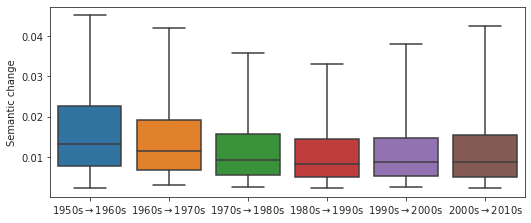

In [45]:
def semantic_change_dist(save=False):
    """"""
    plt.figure(figsize=(8.5, 3.5))
    ax = sns.boxplot(x='variable', y='value', data=vid_change_df.melt(id_vars=['vid', 'name']), whis=(5,95), showfliers=False) 
    xticklabels = [t.get_text()[:5]+r'$\rightarrow$'+t.get_text()[-5:] for t in ax.get_xticklabels()]
    ax.set(xticklabels=xticklabels, xlabel='', ylabel='Semantic change')
    if save:
        plt.savefig('../figs/jnl_local_dist_hist.pdf', bbox_inches='tight')

semantic_change_dist(True)

In [229]:
vid_change_df.sort_values(by='ConsecChangeSum', ascending=False)[880:900]

,vid,name,1950sTo1960s,1960sTo1970s,1970sTo1980s,1980sTo1990s,1990sTo2000s,2000sTo2010s,ConsecChangeSum
20811,24688465,Physica D: Nonlinear Phenomena,0.007240,0.017580,0.046739,0.024519,0.008125,0.005067,0.109271
18711,164884734,Annales Des Télécommunications,0.013172,0.014626,0.032318,0.013577,0.021542,0.013966,0.109200
1670,2764824859,Zahedan Journal of Research in Medical Sciences,NaN,NaN,NaN,NaN,NaN,0.109150,0.109150
17054,108758393,Progress in Lipid Research,NaN,NaN,0.067466,0.027890,0.005476,0.008281,0.109113
22265,32573412,Simulation,NaN,0.023151,0.036004,NaN,NaN,0.049942,0.109098
17420,1129385027,international conference on information system...,NaN,NaN,NaN,NaN,0.101051,0.008041,0.109092
21496,2764666458,Chemical engineering education,NaN,NaN,NaN,0.071760,0.022158,0.015166,0.109085
20222,2764925112,Self and society,NaN,NaN,0.021996,0.008016,0.032577,0.046437,0.109026
4419,133775183,Rubber Chemistry and Technology,0.068302,0.011122,0.011757,0.003533,0.005892,0.008397,0.109003
24595,82779230,Annual Review of Microbiology,0.031298,0.025994,0.036543,0.007988,0.006188,0.000970,0.108981


In [226]:
vid_change_df[vid_change_df.vid == '2764851895'].values

array([['2764851895',
        'Journal of the royal statistical society series b-methodological',
        0.013501449220979844, 0.03106170718013479, 0.012179933588538638,
        0.021639511242570686, 0.01812990843854989, 0.015922718667313762,
        0.11243522833808761]], dtype=object)

In [165]:
case_venues = [('Annals of the New York Academy of Sciences', 'Ann N Y Acad Sci'), 
               ('Philosophical transactions - Royal Society. Mathematical, physical and engineering sciences', 'Philos Trans R Soc'), 
               ('Advances in pharmacology', 'Adv Pharmacol'), 
               ('Philosophical Transactions of the Royal Society A', 'Philos Trans R Soc A'), 
               ('Proceedings of The Royal Society B: Biological Sciences', 'Proc R Soc B'), 
               ('Philosophical Transactions of the Royal Society B', 'Philos Trans R Soc B'), 
               ('Yale Journal of Biology and Medicine', 'Yale J Biol Med'),
               # ('Adolescent Psychiatry', ''), 
               ('Bulletin of Mathematical Biology', 'Bull Math Biol'), 
               ('Mount Sinai Journal of Medicine', 'Mt Sinai J Med'), 
               ('Advances in internal medicine', 'Adv Int Med'), 
               ('Advances in Cardiology', 'Adv Cardiology'), 
               ('The Imaging Science Journal', 'Imaging Sci J'), 
               ('Protein Science', 'Protein Sci'), 
               ('American Journal of Physics', 'Am J Phys'), 
               ('Transactions of The American Philosophical Society', 'Trans Am Philos Soc'), 
               ('The Journal of Antibiotics', 'J Antibiot'), 
               ('Journal of Biological Physics', 'J Biol Phys'), 
               ('Chemotherapy', 'Chemotherapy'), 
               ('Advances in Genetics', 'Adv Genet'), 
               ('European Journal of Haematology', 'Eur J Haematol'), 
               ('Journal of the Acoustical Society of America', 'J Acoust Soc Am'), 
               ('Cognitive Science', 'Cogn Sci'), 
              ('Journal of The Royal Statistical Society Series C-applied Statistics', 'J R Stat Soc C'), 
              ('The American review of respiratory disease', 'Am Rev Respir Dis'), 
              ('Econometrica', 'Econometrica'), 
              ('Science', 'Science'), 
              ('Nature', 'Nature'), 
              ('Proceedings of the National Academy of Sciences of the United States of America', 'PNAS'),
              ('The Lancet', 'Lancet'), 
              ('The New England Journal of Medicine', 'NEJM'), 
              ('JAMA', 'JAMA'), 
              ('BMJ', 'BMJ'), 
              ('British Journal of Radiology', 'Br J Radiol'), 
              ('American Journal of Public Health', 'Am J Public Health'), 
              ('Angewandte Chemie', 'Angewandte Chemie'), 
              ('Bioinformatics', 'Bioinformatics'), 
              ('Science of The Total Environment', 'Sci Total Environ'), 
              ('Management Science', 'Manag Sci'), 
              ('Journal of Biological Chemistry', 'J Biol Chem'), 
              ('The Journal of Infectious Diseases', 'J Infect Dis'), 
              ('meeting of the association for computational linguistics', 'ACL'), 
              ('Physical Review Letters', 'Phys Rev Lett'), 
              ('Physical Review D', 'Phys Rev D'), 
              ('The Astrophysical Journal', 'Astrophys J'),
              ('Journal of the American Chemical Society', 'J Am Chem Soc'),
              ('Annals of Mathematics', 'Ann Math'), 
              ('Quarterly Journal of Economics', 'Q J Econ'), 
              ('American Sociological Review', 'Am Sociol Rev'), 
              ('IEEE Transactions on Information Theory', 'IEEE Trans Inf Theory')
             ]
case_venues = [(v, vb, vid_change_df[vid_change_df.name == v].iloc[0]['ConsecChangeSum']) for v, vb in case_venues]
case_venues = sorted(case_venues, key=lambda x: x[2], reverse=True)
len(case_venues)

49

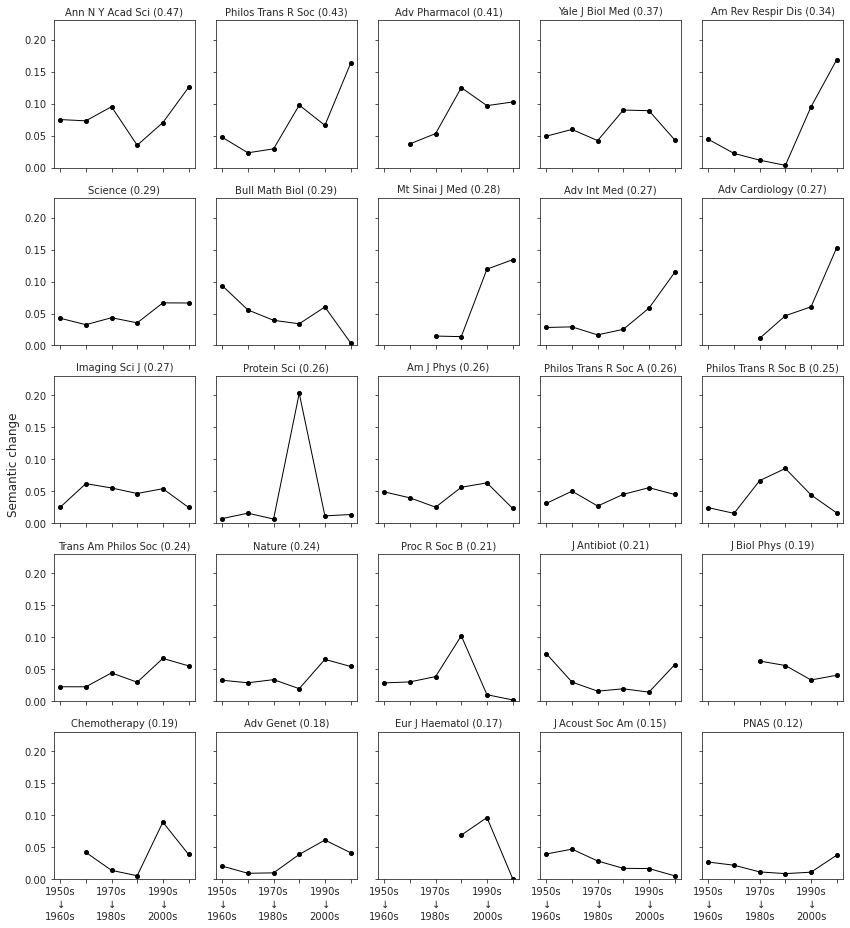

In [167]:
def plot_venue_semantic_change_1(save=False):
    """"""
    decade_col = sorted(semantic_change_consecutive)
    fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,13))
    axes = axes.flatten()
    for (v, vb, t), ax in zip(case_venues[0:25], axes):
        row = vid_change_df[vid_change_df.name == v].iloc[0]
        row[decade_col].plot(ax=ax, color='k', ylim=[0,.23], lw=1, xticks=range(0,6), marker='.', markersize=8)
        ax.set_title(f"{vb} ({t:.2f})", fontsize=10)
        ax.set(xticklabels=['']*6)
    axes[-1].set(xticklabels=['1950s\n$\downarrow$\n1960s', '', '1970s\n$\downarrow$\n1980s', '', '1990s\n$\downarrow$\n2000s', ''])
    fig.supylabel('Semantic change')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/venue_local_dist_cases_1.pdf', bbox_inches='tight')

plot_venue_semantic_change_1(True)

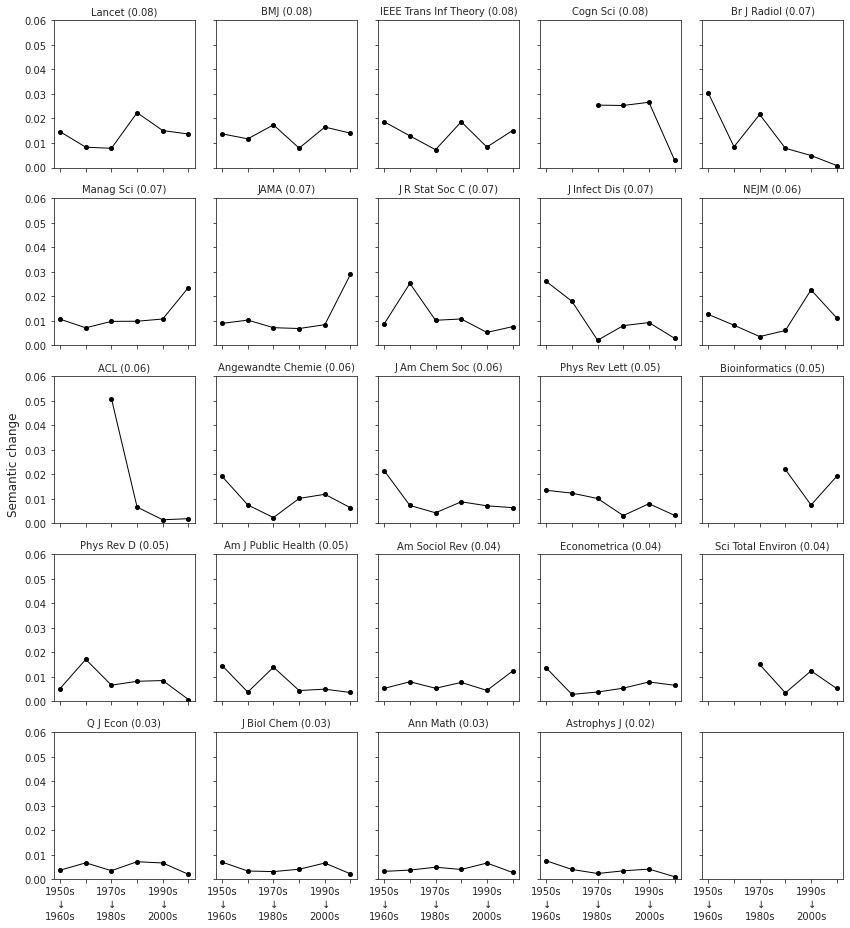

In [168]:
def plot_venue_semantic_change_2(save=False):
    """"""
    decade_col = sorted(semantic_change_consecutive)
    fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,13))
    axes = axes.flatten()
    for (v, vb, t), ax in zip(case_venues[25:50], axes):
        row = vid_change_df[vid_change_df.name == v].iloc[0]
        row[decade_col].plot(ax=ax, color='k', ylim=[0,.06], lw=1, xticks=range(0,6), marker='.', markersize=8)
        ax.set_title(f"{vb} ({t:.2f})", fontsize=10)
        ax.set(xticklabels=['']*6)
    axes[-1].set(xticklabels=['1950s\n$\downarrow$\n1960s', '', '1970s\n$\downarrow$\n1980s', '', '1990s\n$\downarrow$\n2000s', ''])
    fig.supylabel('Semantic change')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/venue_local_dist_cases_2.pdf', bbox_inches='tight')

plot_venue_semantic_change_2(True)

In [211]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['1950s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,54861105,Transactions of The Ire Professional Group on ...,0.675863
1,62507282,Journal of The Audio Engineering Society,0.647232
2,29481409,Noise Control,0.581486
3,2756303323,ire national convention,0.568726
4,137261208,Language and Speech,0.561815
5,36919197,Ire Transactions on Audio,0.551956
6,128239818,Ire Transactions on Aeronautical and Navigatio...,0.547794
7,11838608,Ire Transactions on Automatic Control,0.523983
8,158263287,Iete Journal of Research,0.520386
9,2737956264,Annual of Navigation,0.519967


In [212]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['1960s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,971171794,Applied Acoustics,0.659527
1,11857717,British Journal of Audiology,0.608811
2,36919197,Ire Transactions on Audio,0.587089
3,186564409,IEEE Transactions on Audio,0.583887
4,110744938,Journal of Speech Language and Hearing Research,0.577884
5,135492789,Physical Acoustics,0.561598
6,62322205,Audiology,0.557604
7,62507282,Journal of The Audio Engineering Society,0.550797
8,99182027,Journal of Sound and Vibration,0.540695
9,167084610,American Annals of the Deaf,0.540139


In [213]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['1970s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,2764506352,Research publications - Association for Resear...,0.637882
1,2764762583,Journal of the American Audiology Society,0.623039
2,62322205,Audiology,0.621794
3,57797550,Noise Control Engineering,0.619929
4,137490058,Phonetica,0.604923
5,20677110,Folia Phoniatrica Et Logopaedica,0.604100
6,42504509,Journal of Phonetics,0.601335
7,82774605,Hearing Research,0.600422
8,43570703,Acustica,0.591310
9,62507282,Journal of The Audio Engineering Society,0.569135


In [214]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['1980s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,43570703,Acustica,0.754423
1,137490058,Phonetica,0.651829
2,57797550,Noise Control Engineering,0.640466
3,135492789,Physical Acoustics,0.625869
4,42504509,Journal of Phonetics,0.594147
5,65891225,The Journal of The Acoustical Society of Japan...,0.593538
6,2764779072,The Journal of auditory research,0.591194
7,203414176,Materials evaluation,0.585153
8,42775958,Ear and Hearing,0.584092
9,82774605,Hearing Research,0.583012


In [215]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['1990s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,2764925253,The Journal of the Acoustical Society of Japan,0.715361
1,65891225,The Journal of The Acoustical Society of Japan...,0.708275
2,207226196,Acoustical Physics,0.703443
3,129421594,Journal of Computational Acoustics,0.703093
4,2764506007,Canadian Acoustics,0.692343
5,2765048474,Acoustics letters,0.682350
6,200200930,Trends in Amplification,0.655482
7,135492789,Physical Acoustics,0.644182
8,2764881414,The Hearing journal,0.636857
9,168745376,Ultrasonics,0.628842


In [216]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['2000s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,70188032,Acoustics Research Letters Online-arlo,0.854318
1,971171794,Applied Acoustics,0.815696
2,2764506007,Canadian Acoustics,0.812080
3,43570703,Acustica,0.794225
4,50311296,Acta Acustica United With Acustica,0.788316
5,207226196,Acoustical Physics,0.783248
6,13633155,Acoustics Today,0.751430
7,177137575,Acoustical Science and Technology,0.729823
8,80222133,The Open Acoustics Journal,0.696724
9,121334040,Bioacoustics-the International Journal of Anim...,0.689710


In [217]:
pd.DataFrame([[str(int(n)), vid_name[str(int(n))], s] for n, s in dec_wv_models['2010s'].most_similar(11296630, topn=10)], columns=['nei_vid', 'nei_name', 'sim'])

,nei_vid,nei_name,sim
0,971171794,Applied Acoustics,0.834167
1,50311296,Acta Acustica United With Acustica,0.829829
2,13633155,Acoustics Today,0.807201
3,156092988,Acoustics Australia,0.805014
4,2764506007,Canadian Acoustics,0.760150
5,177137575,Acoustical Science and Technology,0.756419
6,146157322,Archives of Acoustics,0.752772
7,46035623,Noise Control Engineering Journal,0.736014
8,129421594,Journal of Computational Acoustics,0.735213
9,2764869302,New Zealand Acoustics,0.732700


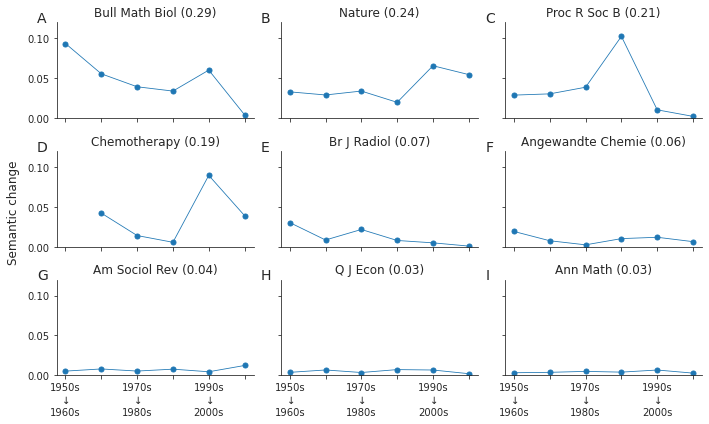

In [209]:
def plot_venue_semantic_change_main(save=False):
    """"""
    venues = [('Bulletin of Mathematical Biology', 'Bull Math Biol'), 
              ('Proceedings of The Royal Society B: Biological Sciences', 'Proc R Soc B'), 
              ('Nature', 'Nature'), 
              ('Chemotherapy', 'Chemotherapy'), 
              ('British Journal of Radiology', 'Br J Radiol'), 
              ('Angewandte Chemie', 'Angewandte Chemie'), 
              ('Annals of Mathematics', 'Ann Math'), 
              ('Quarterly Journal of Economics', 'Q J Econ'), 
              ('American Sociological Review', 'Am Sociol Rev')
             ]
    venues = [(v, vb, vid_change_df[vid_change_df.name == v].iloc[0]['ConsecChangeSum']) for v, vb in venues]
    venues = sorted(venues, key=lambda x: x[2], reverse=True)
    decade_col = sorted(semantic_change_consecutive)
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,6))
    axes = axes.flatten()
    for (v, vb, t), ax, lbl in zip(venues, axes, string.ascii_uppercase):
        row = vid_change_df[vid_change_df.name == v].iloc[0]
        row[decade_col].plot(ax=ax, ylim=[0,.12], lw=.8, xticks=range(0,6), marker='.', markersize=10)
        ax.set_title(f"{vb} ({t:.2f})")
        ax.text(-.1, 1, lbl, transform=ax.transAxes, fontsize=14)
        ax.spines[['right', 'top']].set_visible(False)
    axes[-1].set(xticklabels=['1950s\n$\downarrow$\n1960s', '', '1970s\n$\downarrow$\n1980s', '', '1990s\n$\downarrow$\n2000s', ''])
    fig.supylabel('Semantic change')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/venue_local_dist_main.pdf', bbox_inches='tight')

plot_venue_semantic_change_main(True)